In [1]:
from collections import defaultdict
from datetime import datetime, timedelta, timezone
import pandas as pd
import yaml

import matplotlib.pyplot as plt
import seaborn as sns

from scripts.oso_db import execute_query, query_and_dump_to_csv
from visualizations.contribution_heatmap import contribution_heatmap
from visualizations.venn_diagram import venn3_diagram
from visualizations.stacked_area import activity_plot

In [8]:
cp_mapping = {}
op_slugs = []
collection_slugs = ["op-govgrants", "op-rpgf2", "op-onchain"]
collection_dir = "../../oss-directory/data/collections/"
for slug in collection_slugs:
    pathname = collection_dir + slug + '.yaml'
    with open(pathname) as f:
        y = yaml.safe_load(f)
        cp_mapping[slug] = y['projects']
        op_slugs.extend(y['projects'])
cp_mapping['optimism'] = sorted(list(set(op_slugs)))

In [3]:
grants_df = pd.read_json("data/2023-10-01_op_tracked_grants.json")
grants_df['collection'] = grants_df['tags'].apply(lambda x: 'op-rpgf2' if 'RPGF2' in x else 'op-govgrants')
get_stats = lambda x: x.groupby('collection')['amount'].agg(['count', 'sum']).T.to_dict()
grant_stats = {
    "all_grants": get_stats(grants_df),
    "oss_grants": get_stats(grants_df[grants_df['slug'] != ""])
}
grant_stats

{'all_grants': {'op-govgrants': {'count': 240, 'sum': 68792330},
  'op-rpgf2': {'count': 195, 'sum': 10000007}},
 'oss_grants': {'op-govgrants': {'count': 194, 'sum': 65548249},
  'op-rpgf2': {'count': 140, 'sum': 8223408}}}

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

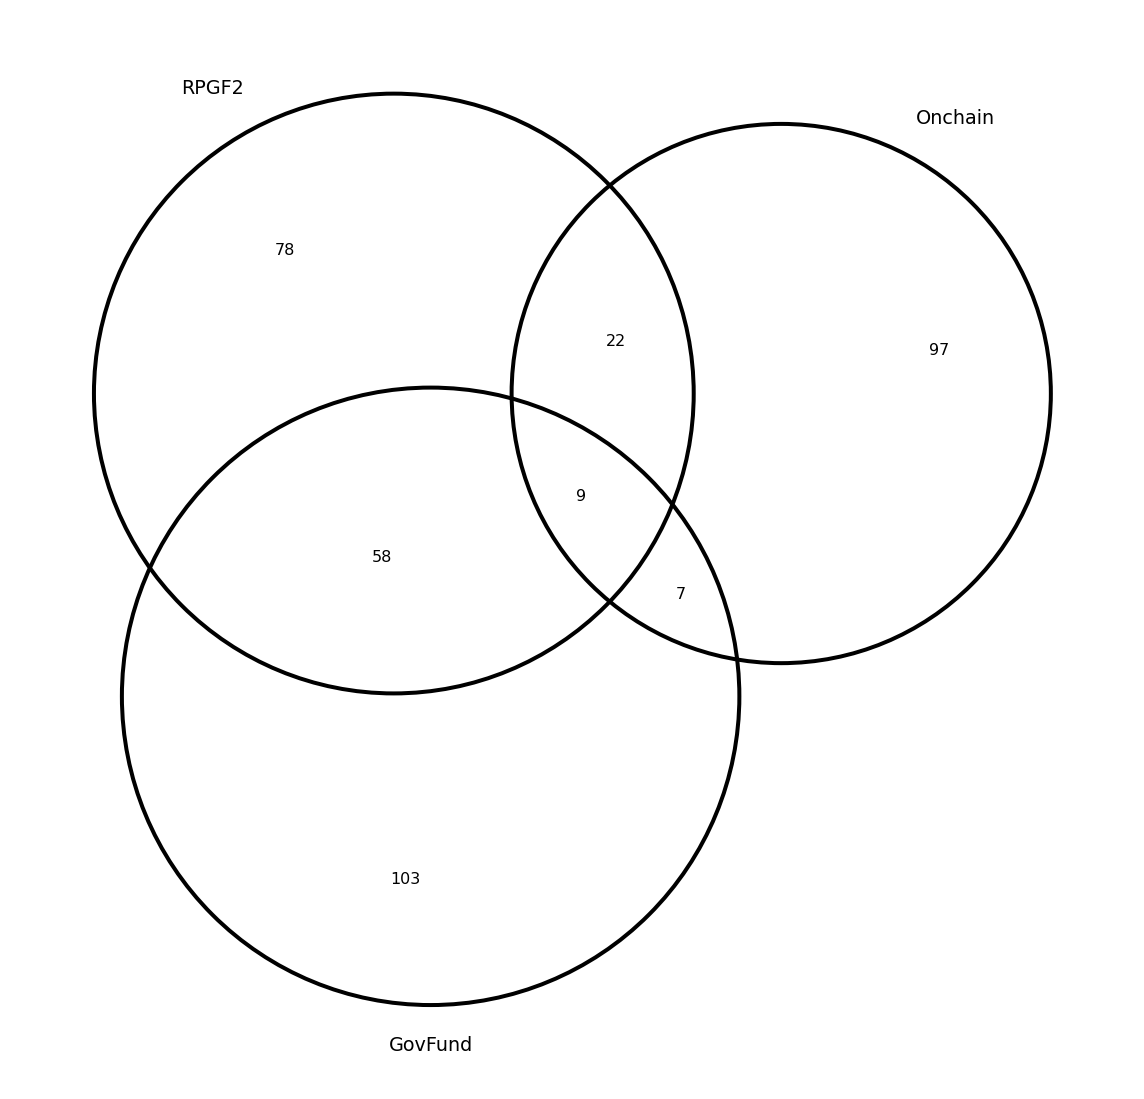

In [7]:
venn3_diagram(
    [set(ps) for c,ps in cp_mapping.items() if c in collection_slugs], 
    ["RPGF2", "Onchain", "GovFund"]
)

In [24]:
#QUERY_PARAMS = ("2017-01-01", "optimism")

# Analyze repos

In [21]:
repos_path = query_and_dump_to_csv("repo_stats")

Results dumped to: ../data/2023-10-12_repo_stats.csv


In [60]:
rdf = pd.read_csv(repos_path)
rdf.head()

project_slug     project_name                    artifact_name  \
0              0u0-ai           0u0.ai                       0u0-ai/0u0   
1              0u0-ai           0u0.ai                   0u0-ai/backend   
2  0x-boring-security  Boring Security       0xBoringSecurity/Class1155   
3        0x-dead-list       0xDeadList            0xDeadList/0xDeadList   
4        0x-dead-list       0xDeadList  0xDeadList/0xDeadList-StarkWare   

   stars_count  num_contributors                 first_date  \
0            1                 4  2023-02-21 06:43:09+00:00   
1            0                 1  2023-05-02 14:46:27+00:00   
2            0                 1  2022-03-12 23:45:46+00:00   
3           24                 4  2022-07-23 15:29:40+00:00   
4            2                 2  2023-04-02 21:15:57+00:00   

                   last_date  
0  2023-10-04 00:00:00+00:00  
1  2023-05-04 12:54:57+00:00  
2  2023-10-04 00:00:00+00:00  
3  2023-10-06 23:03:42+00:00  
4  2023-10-04 00:00:00+00:00

In [61]:
repos_df = rdf.groupby(['project_slug', 'project_name']).agg({
    "artifact_name": lambda x: x.count(),
    "stars_count": lambda x: x.sum(),
    "first_date":lambda x: x.min(),
    "last_date": lambda x: x.max()
}).reset_index()

repos_df = repos_df[repos_df['project_slug'].isin(cp_mapping['optimism'])]


today = datetime.now().replace(tzinfo=timezone.utc)
repos_df['days_since_first_commit'] = (today - pd.to_datetime(repos_df['first_date'])).apply(lambda x: x.days)
repos_df['days_since_last_commit'] = (today - pd.to_datetime(repos_df['last_date'])).apply(lambda x: x.days)

repos_df['last_commit_category'] = pd.cut(
    repos_df['days_since_last_commit'],
    bins=[-float('inf'), 30, 100, float('inf')],
    labels=['active', 'dormant', 'inactive'],
    right=False  # Include the left bin edge (e.g., 30 days is active, not dormant)
)

repos_df['stars_category'] = pd.cut(
    repos_df['stars_count'],
    bins=[-float('inf'), 10, 1000, float('inf')],
    labels=['less popular', 'more popular', 'very popular'],
    right=False
)

repos_df['project_age'] = pd.cut(
    repos_df['days_since_first_commit'],
    bins=[-float('inf'), 365*2, 365*4, float('inf')],
    labels=['< 2 years', '2-4 years old', '> 4 years old'],
    right=False
)
print(len(repos_df))
repos_df.head()

369


project_slug                         project_name  artifact_name  \
4      0x-splits                             0xSplits             19   
5        0xbcamp  Optimism Solidity Survivor Bootcamp             28   
11        0xparc                               0xPARC             10   
12        1-inch                                1Inch            142   
16  2-pi-network                          2Pi Network             18   

    stars_count                 first_date                  last_date  \
4           282  2020-06-30 08:25:22+00:00  2023-10-11 00:00:00+00:00   
5             9  2022-07-06 20:39:19+00:00  2023-10-11 00:00:00+00:00   
11         1214  2014-07-08 06:47:10+00:00  2023-10-11 07:09:35+00:00   
12         3526  2012-02-20 00:34:27+00:00  2023-10-11 00:00:00+00:00   
16            6  2018-04-03 05:32:41+00:00  2023-10-04 00:00:00+00:00   

    days_since_first_commit  days_since_last_commit last_commit_category  \
4                      1199                       1               active   
5                       462                       1               active   
11                     3383                       1               active   
12                     4252                       1               active   
16                     2018                       8               active   

   stars_category    project_age  
4    more popular  2-4 years old  
5    less popular      < 2 years  
11   very popular  > 4 years old  
12   very popular  > 4 years old  
16   less popular  > 4 years old

In [62]:
pd.crosstab(repos_df['last_commit_category'], repos_df['stars_category'])

stars_category        less popular  more popular  very popular
last_commit_category                                          
active                          54           223            70
dormant                          4             8             0
inactive                         8             2             0

In [63]:
pd.crosstab(repos_df['last_commit_category'], repos_df['project_age'])

project_age           < 2 years  2-4 years old  > 4 years old
last_commit_category                                         
active                       81            100            166
dormant                       7              5              0
inactive                      5              4              1

(1, 10000)

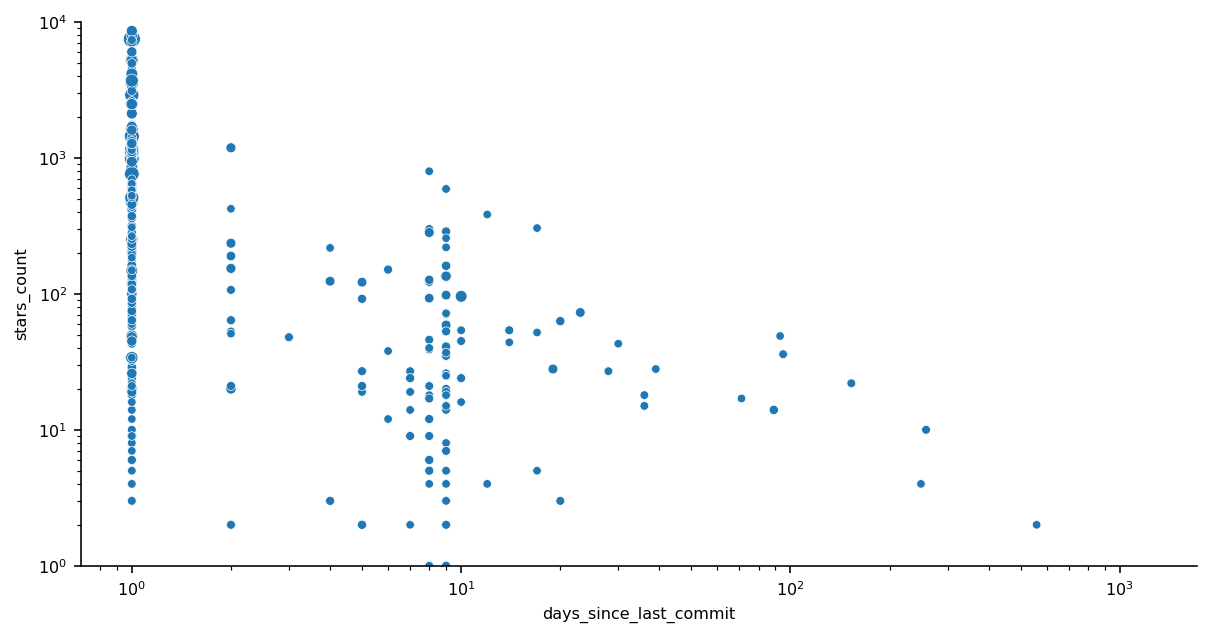

In [68]:
fig, ax = plt.subplots(figsize=(10,5), dpi=144)
sns.scatterplot(
    data=repos_df,
    x='days_since_last_commit',
    y='stars_count',
    size='artifact_name',
    legend=False
)
sns.despine()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1,10000)

# Analyze contributions

In [41]:
contributions_path = query_and_dump_to_csv("monthly_contributors")

Results dumped to: ../data/2023-10-12_monthly_contributors.csv


In [76]:
df = pd.read_csv(contributions_path)
df = df[df['project_slug'].isin(cp_mapping['optimism'])]
df = df[(df['month_year'] < '2023-10') * (df['month_year'] > '2017-01')]

df = df[df['event_type']=='COMMIT_CODE']

df['date'] = pd.to_datetime(df['month_year'])
df['project_name'] = df['project_slug'].map(repos_df.set_index('project_slug')['project_name'].to_dict())
df['age_tag'] = df['project_slug'].map(repos_df.set_index('project_slug')['project_age'].to_dict())
df['activity_tag'] = df['project_slug'].map(repos_df.set_index('project_slug')['last_commit_category'].to_dict())
df['stars_tag'] = df['project_slug'].map(repos_df.set_index('project_slug')['stars_category'].to_dict())
df.head()

project_slug month_year  contributor_id   event_type  num_contributions  \
92    0x-splits    2020-06         33251.0  COMMIT_CODE                 24   
93    0x-splits    2020-06        207563.0  COMMIT_CODE                 12   
94    0x-splits    2021-10         33384.0  COMMIT_CODE                 63   
95    0x-splits    2022-01         33251.0  COMMIT_CODE                 12   
96    0x-splits    2022-01         33384.0  COMMIT_CODE                  3   

         date project_name        age_tag activity_tag     stars_tag  
92 2020-06-01     0xSplits  2-4 years old       active  more popular  
93 2020-06-01     0xSplits  2-4 years old       active  more popular  
94 2021-10-01     0xSplits  2-4 years old       active  more popular  
95 2022-01-01     0xSplits  2-4 years old       active  more popular  
96 2022-01-01     0xSplits  2-4 years old       active  more popular

In [77]:
bot_query = """
    SELECT * FROM event e JOIN artifact a ON a."id" = e."toId" WHERE e."fromId" = 33251 and e."type" = 'COMMIT_CODE'
"""        
bot_detector = df[df['event_type']=='COMMIT_CODE'].groupby('contributor_id').agg({
    "project_slug": lambda x: x.nunique(), 
    "num_contributions": lambda x: sum(x)}).sort_values(by='project_slug').reset_index()

top_bots = bot_detector[(bot_detector['contributor_id'] < 35000) & (bot_detector['project_slug']>5)].sort_values(by='contributor_id')
likely_bots = top_bots['contributor_id'].to_list()
top_bots[top_bots['contributor_id'].isin(likely_bots)].head(3)

contributor_id  project_slug  num_contributions
39098         33251.0           359            3712027
39097         33266.0            59              32293
38991         33331.0             8                344

In [78]:
df = df[~df['contributor_id'].isin(likely_bots)]

(<Figure size 3000x1500 with 1 Axes>,
 <AxesSubplot:ylabel='Total Contributions'>)

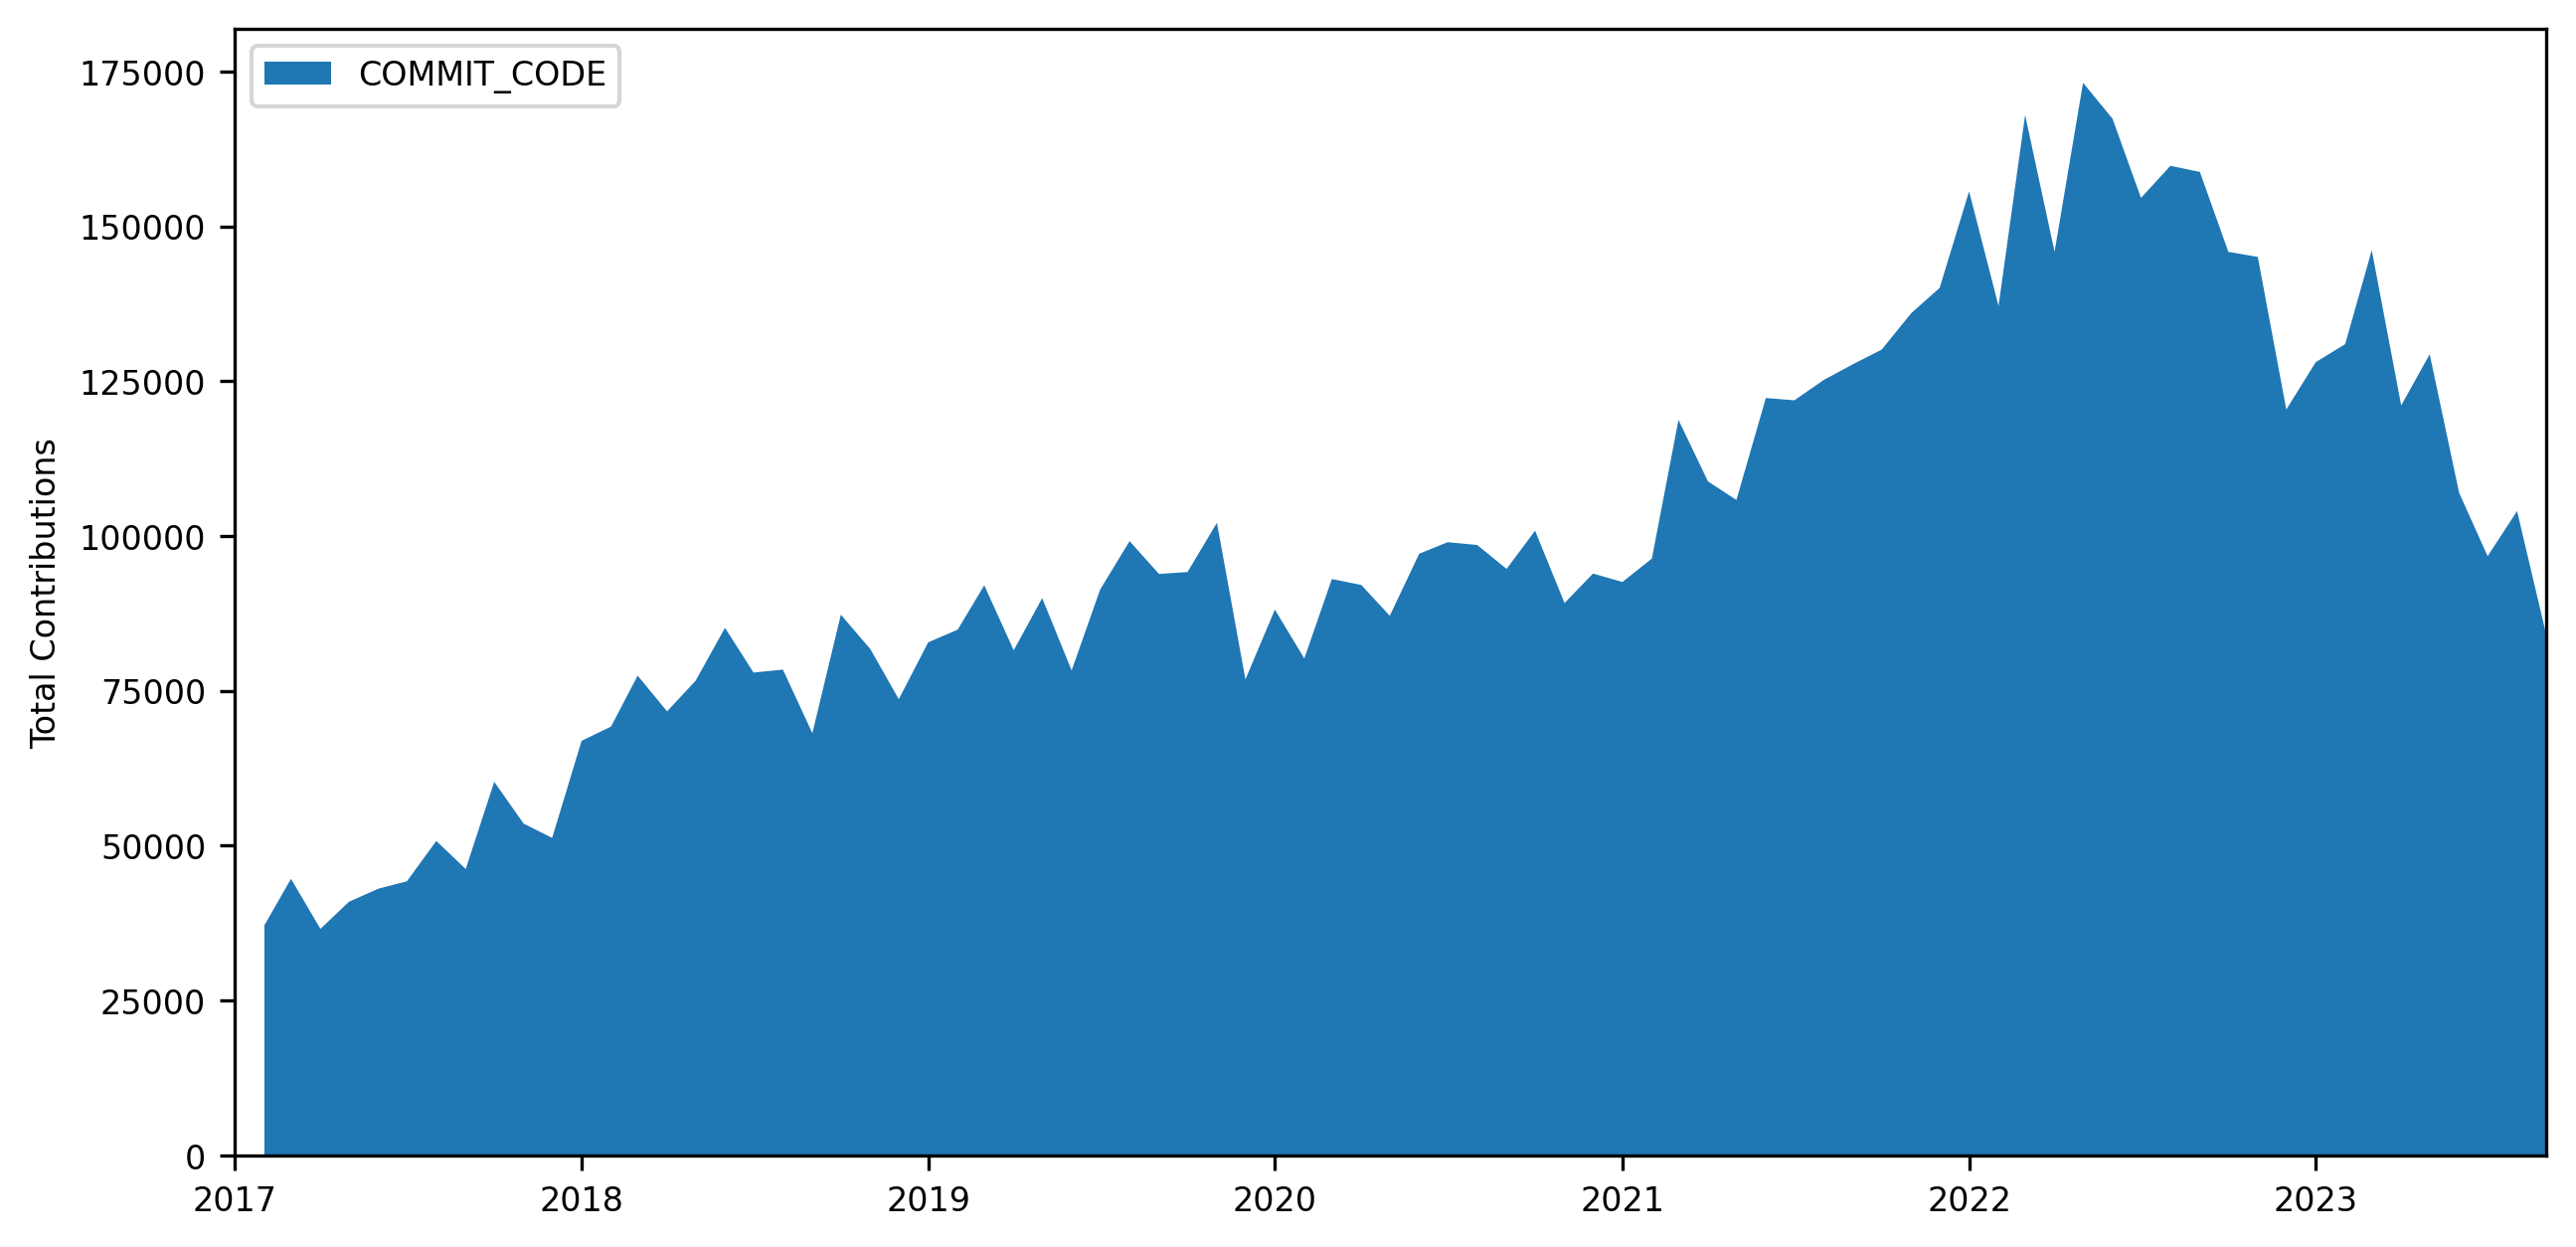

In [79]:
activity_plot(df, 'event_type')

(<Figure size 3000x1500 with 1 Axes>,
 <AxesSubplot:ylabel='Total Contributions'>)

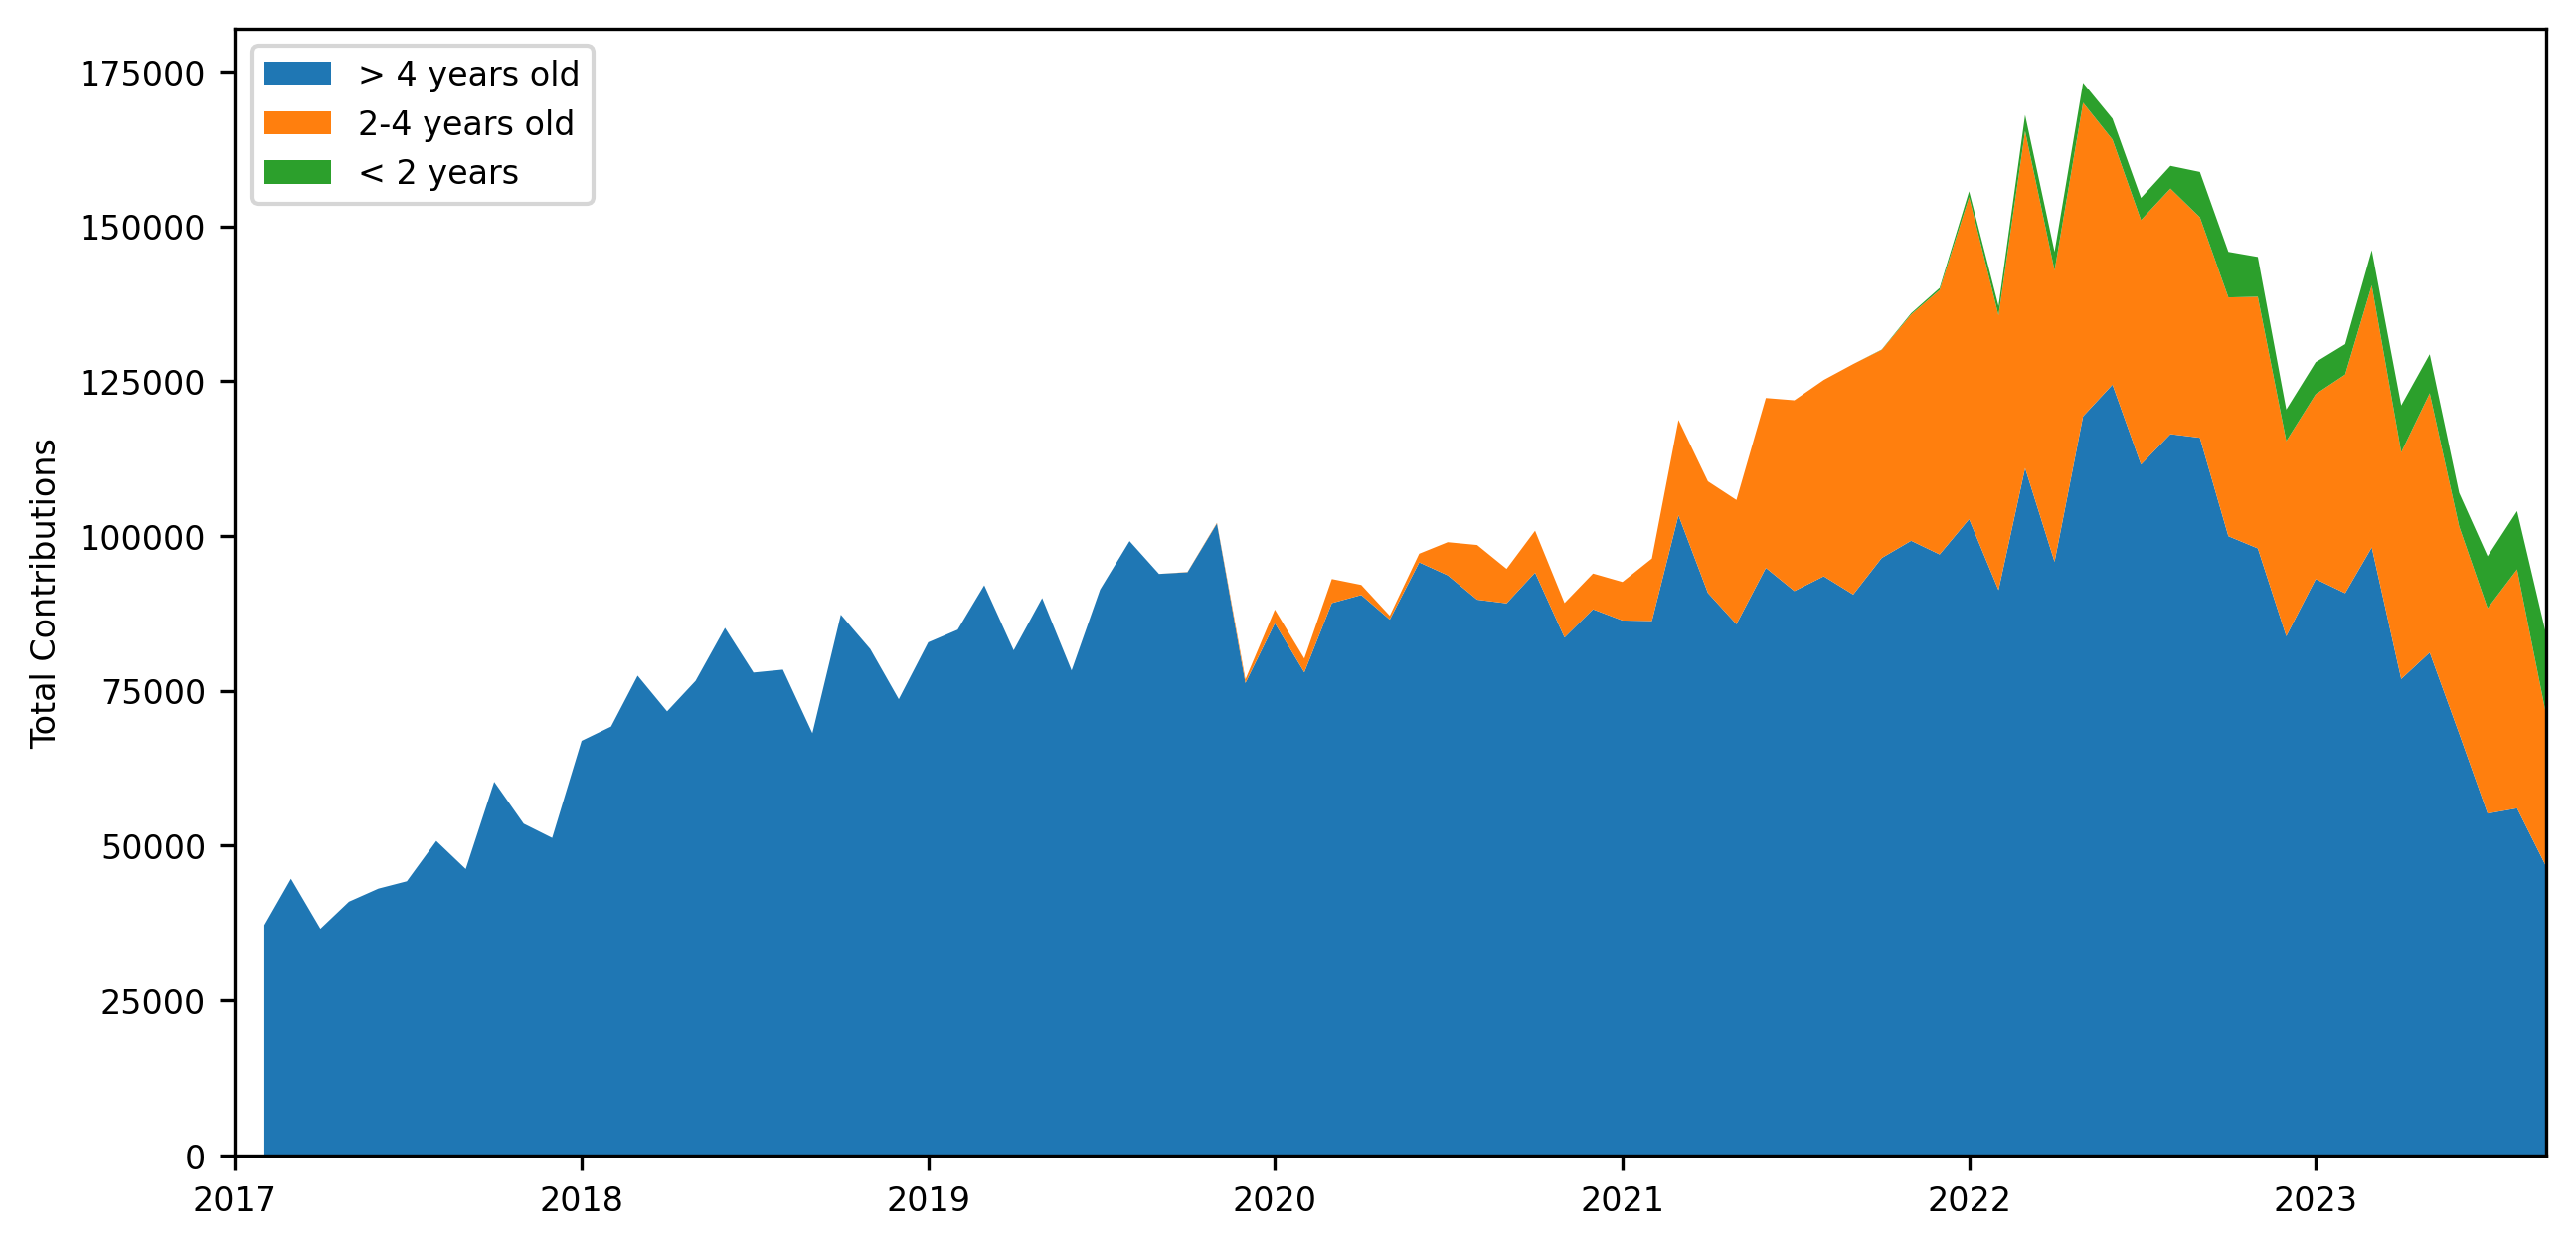

In [80]:
activity_plot(df, 'age_tag')

(<Figure size 3000x1500 with 1 Axes>,
 <AxesSubplot:ylabel='Total Contributions'>)

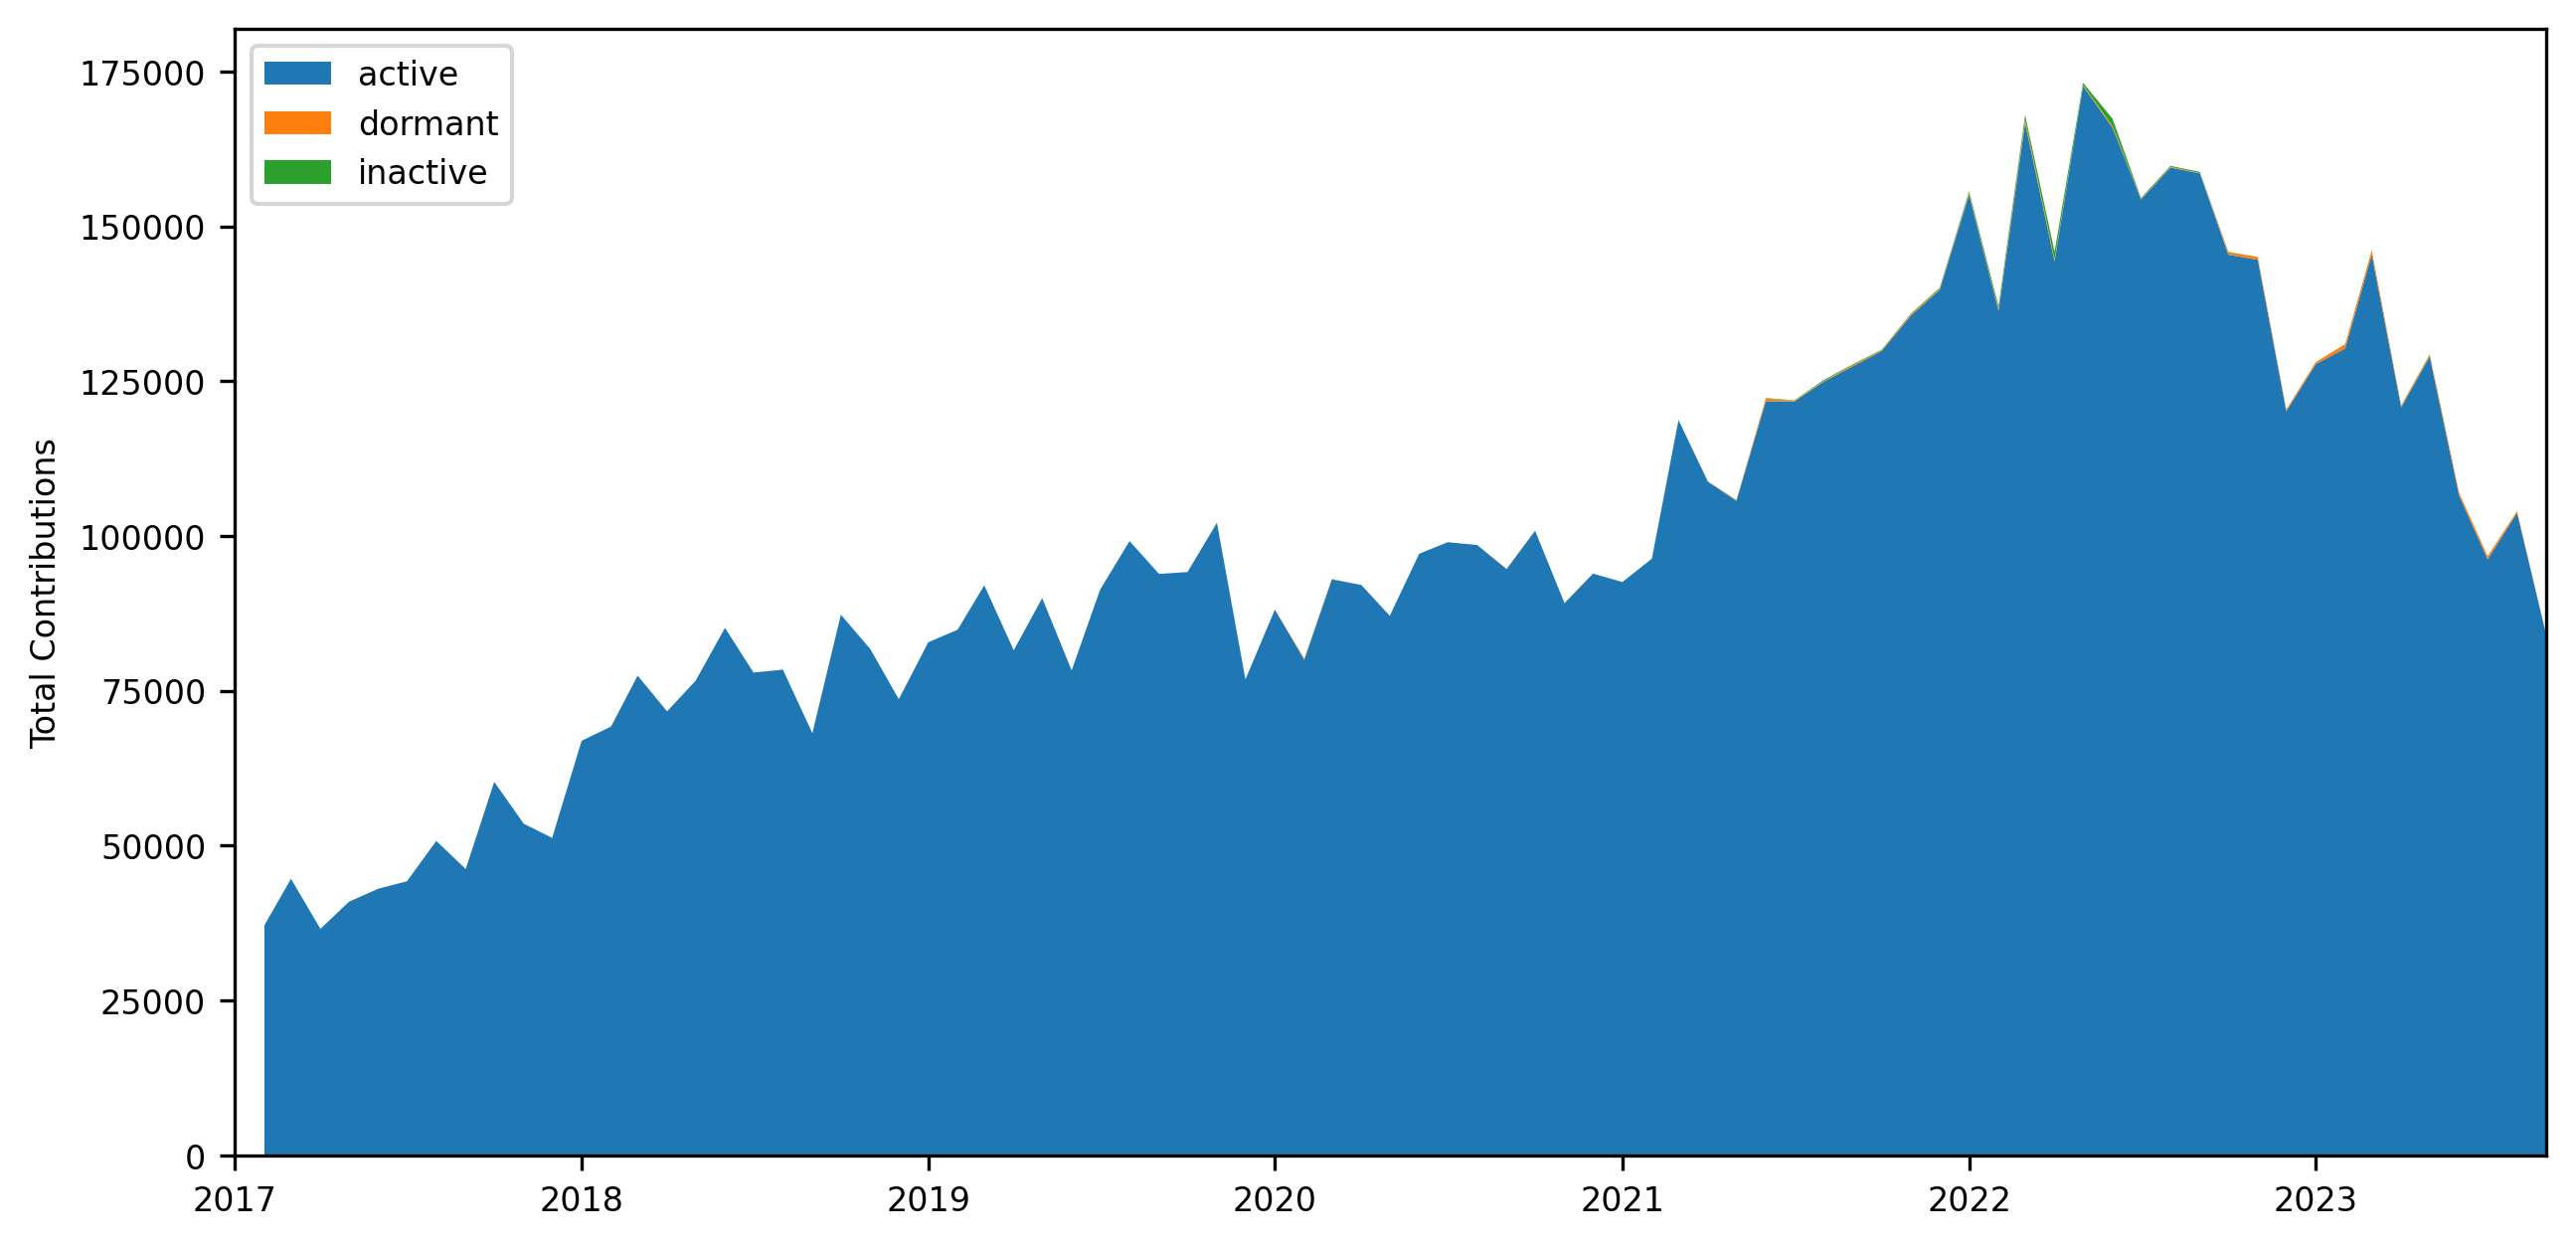

In [81]:
activity_plot(df, 'activity_tag')

(<Figure size 3000x1500 with 1 Axes>,
 <AxesSubplot:ylabel='Total Contributions'>)

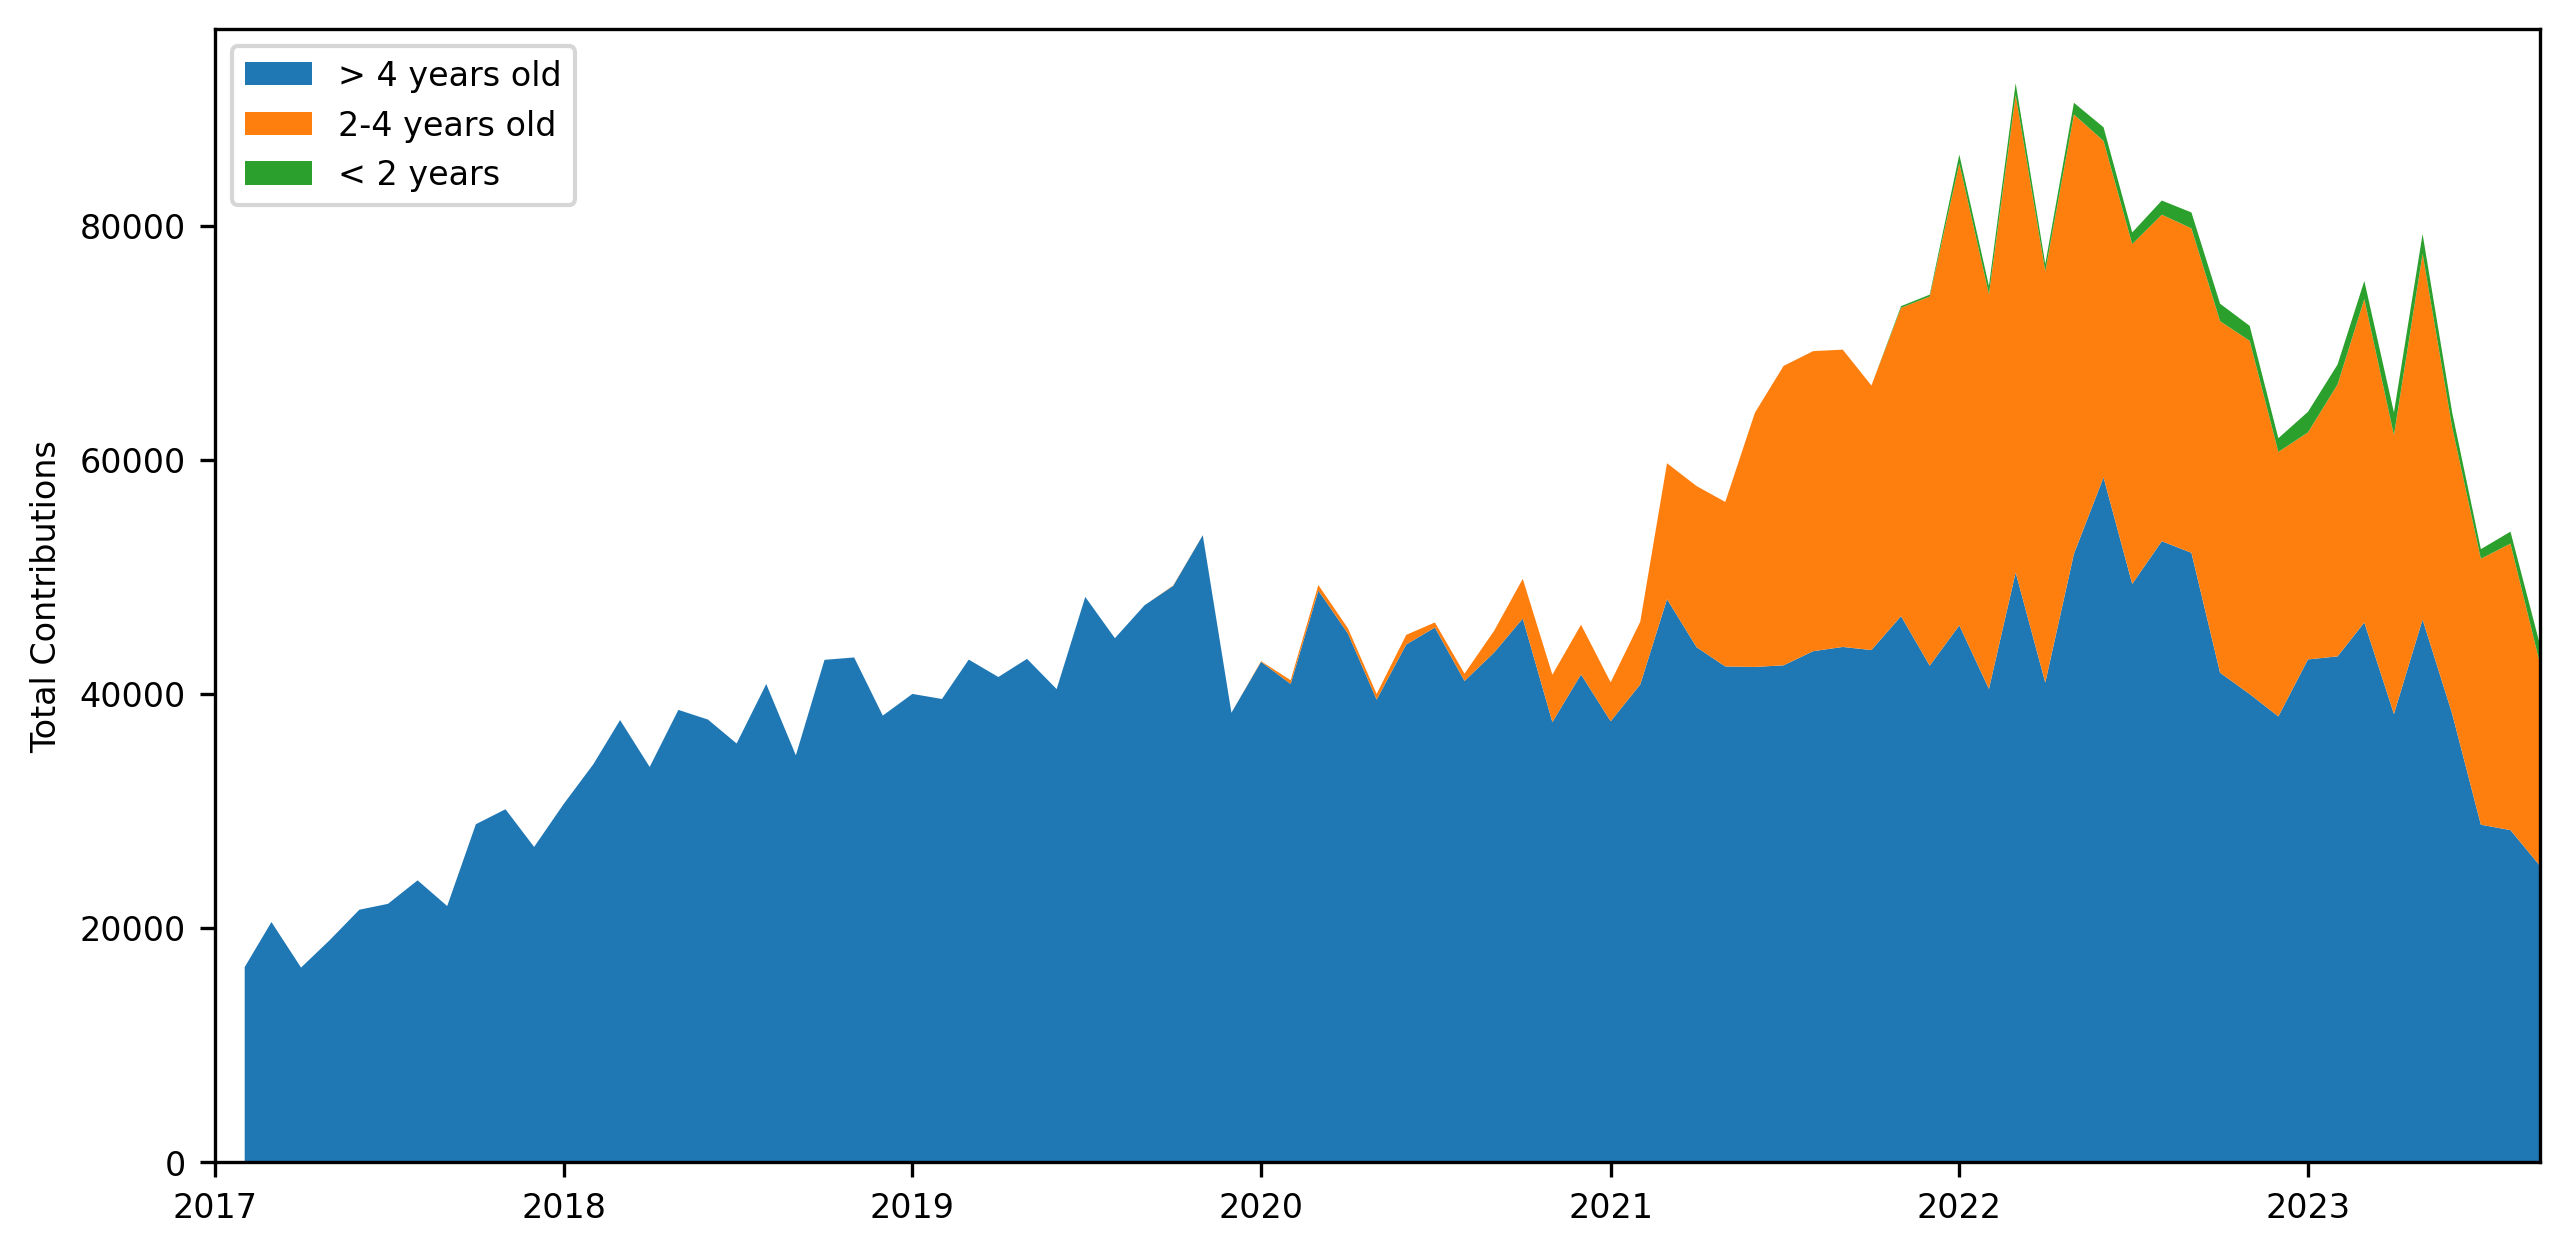

In [82]:
activity_plot(df[df['project_slug'].isin(cp_mapping['op-onchain'])], 'age_tag') 

(<Figure size 4800x10380 with 1 Axes>, <AxesSubplot:>)

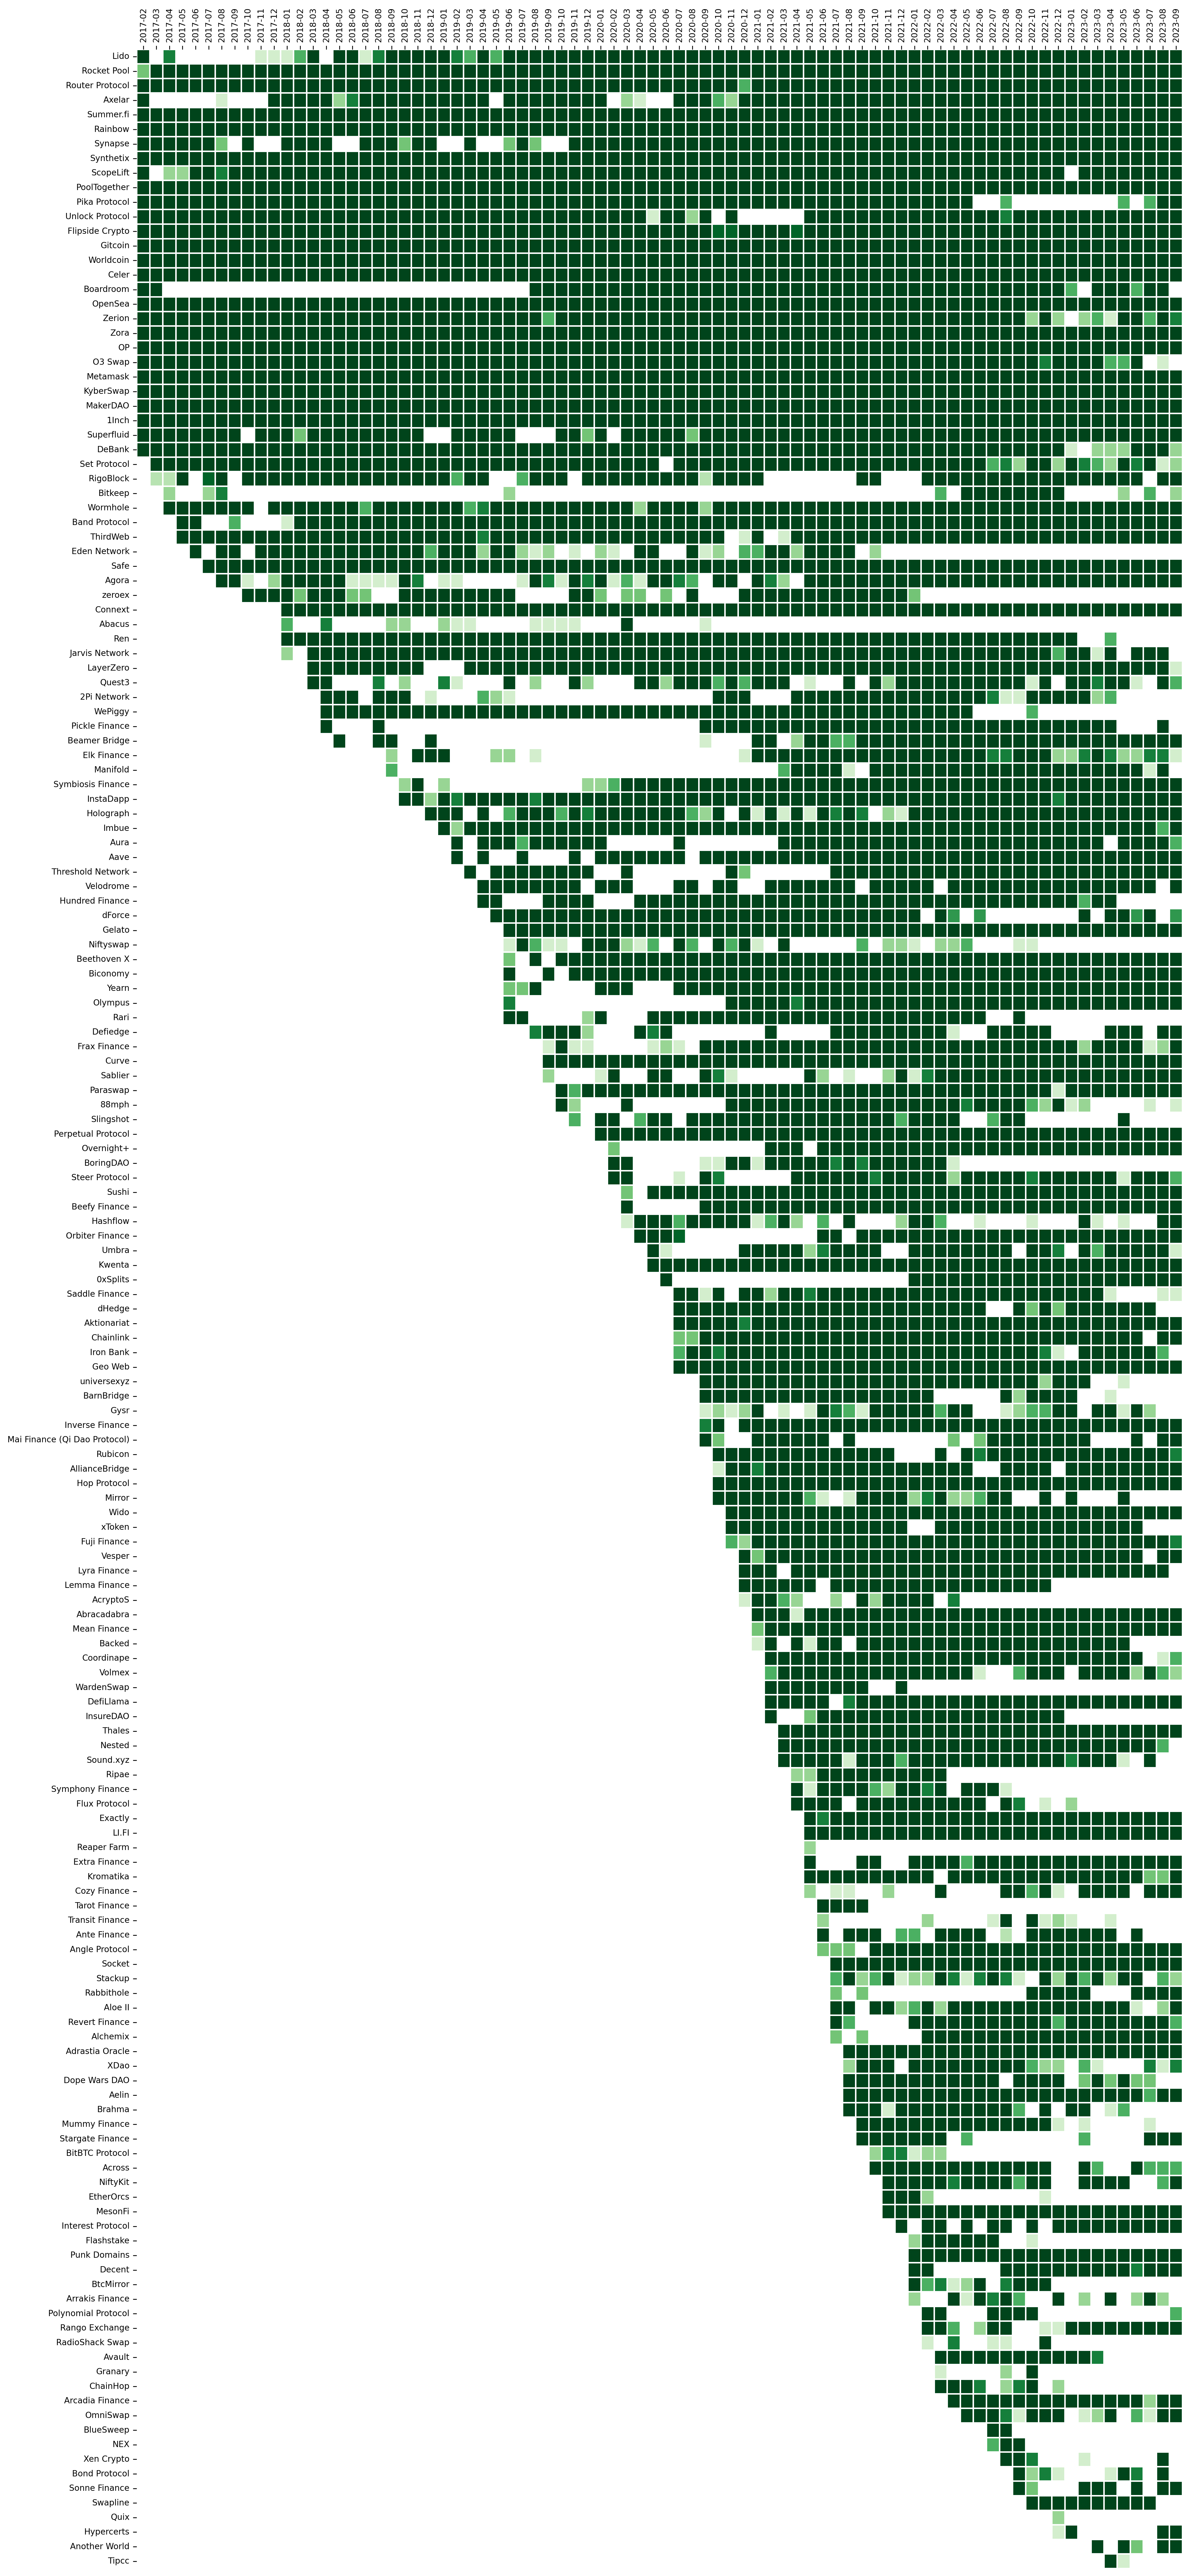

In [83]:
events = (
    df[df['project_slug'].isin(cp_mapping['op-onchain'])]
    .groupby(['project_slug', 'project_name', 'month_year'])['num_contributions']
    .sum()
    .reset_index()
)
events

contribution_heatmap(events, value_col='num_contributions')

In [84]:
contributors = (
    df[df['event_type']=='COMMIT_CODE']
    .groupby(['project_name', 'project_slug', 'month_year'])
    ['contributor_id'].nunique()
    .reset_index()
    .rename(columns={'contributor_id': 'total_contributors'})
)

contribution_heatmap(contributors)

(<Figure size 4800x21780 with 1 Axes>, <AxesSubplot:>)

(<Figure size 4800x7860 with 1 Axes>, <AxesSubplot:>)

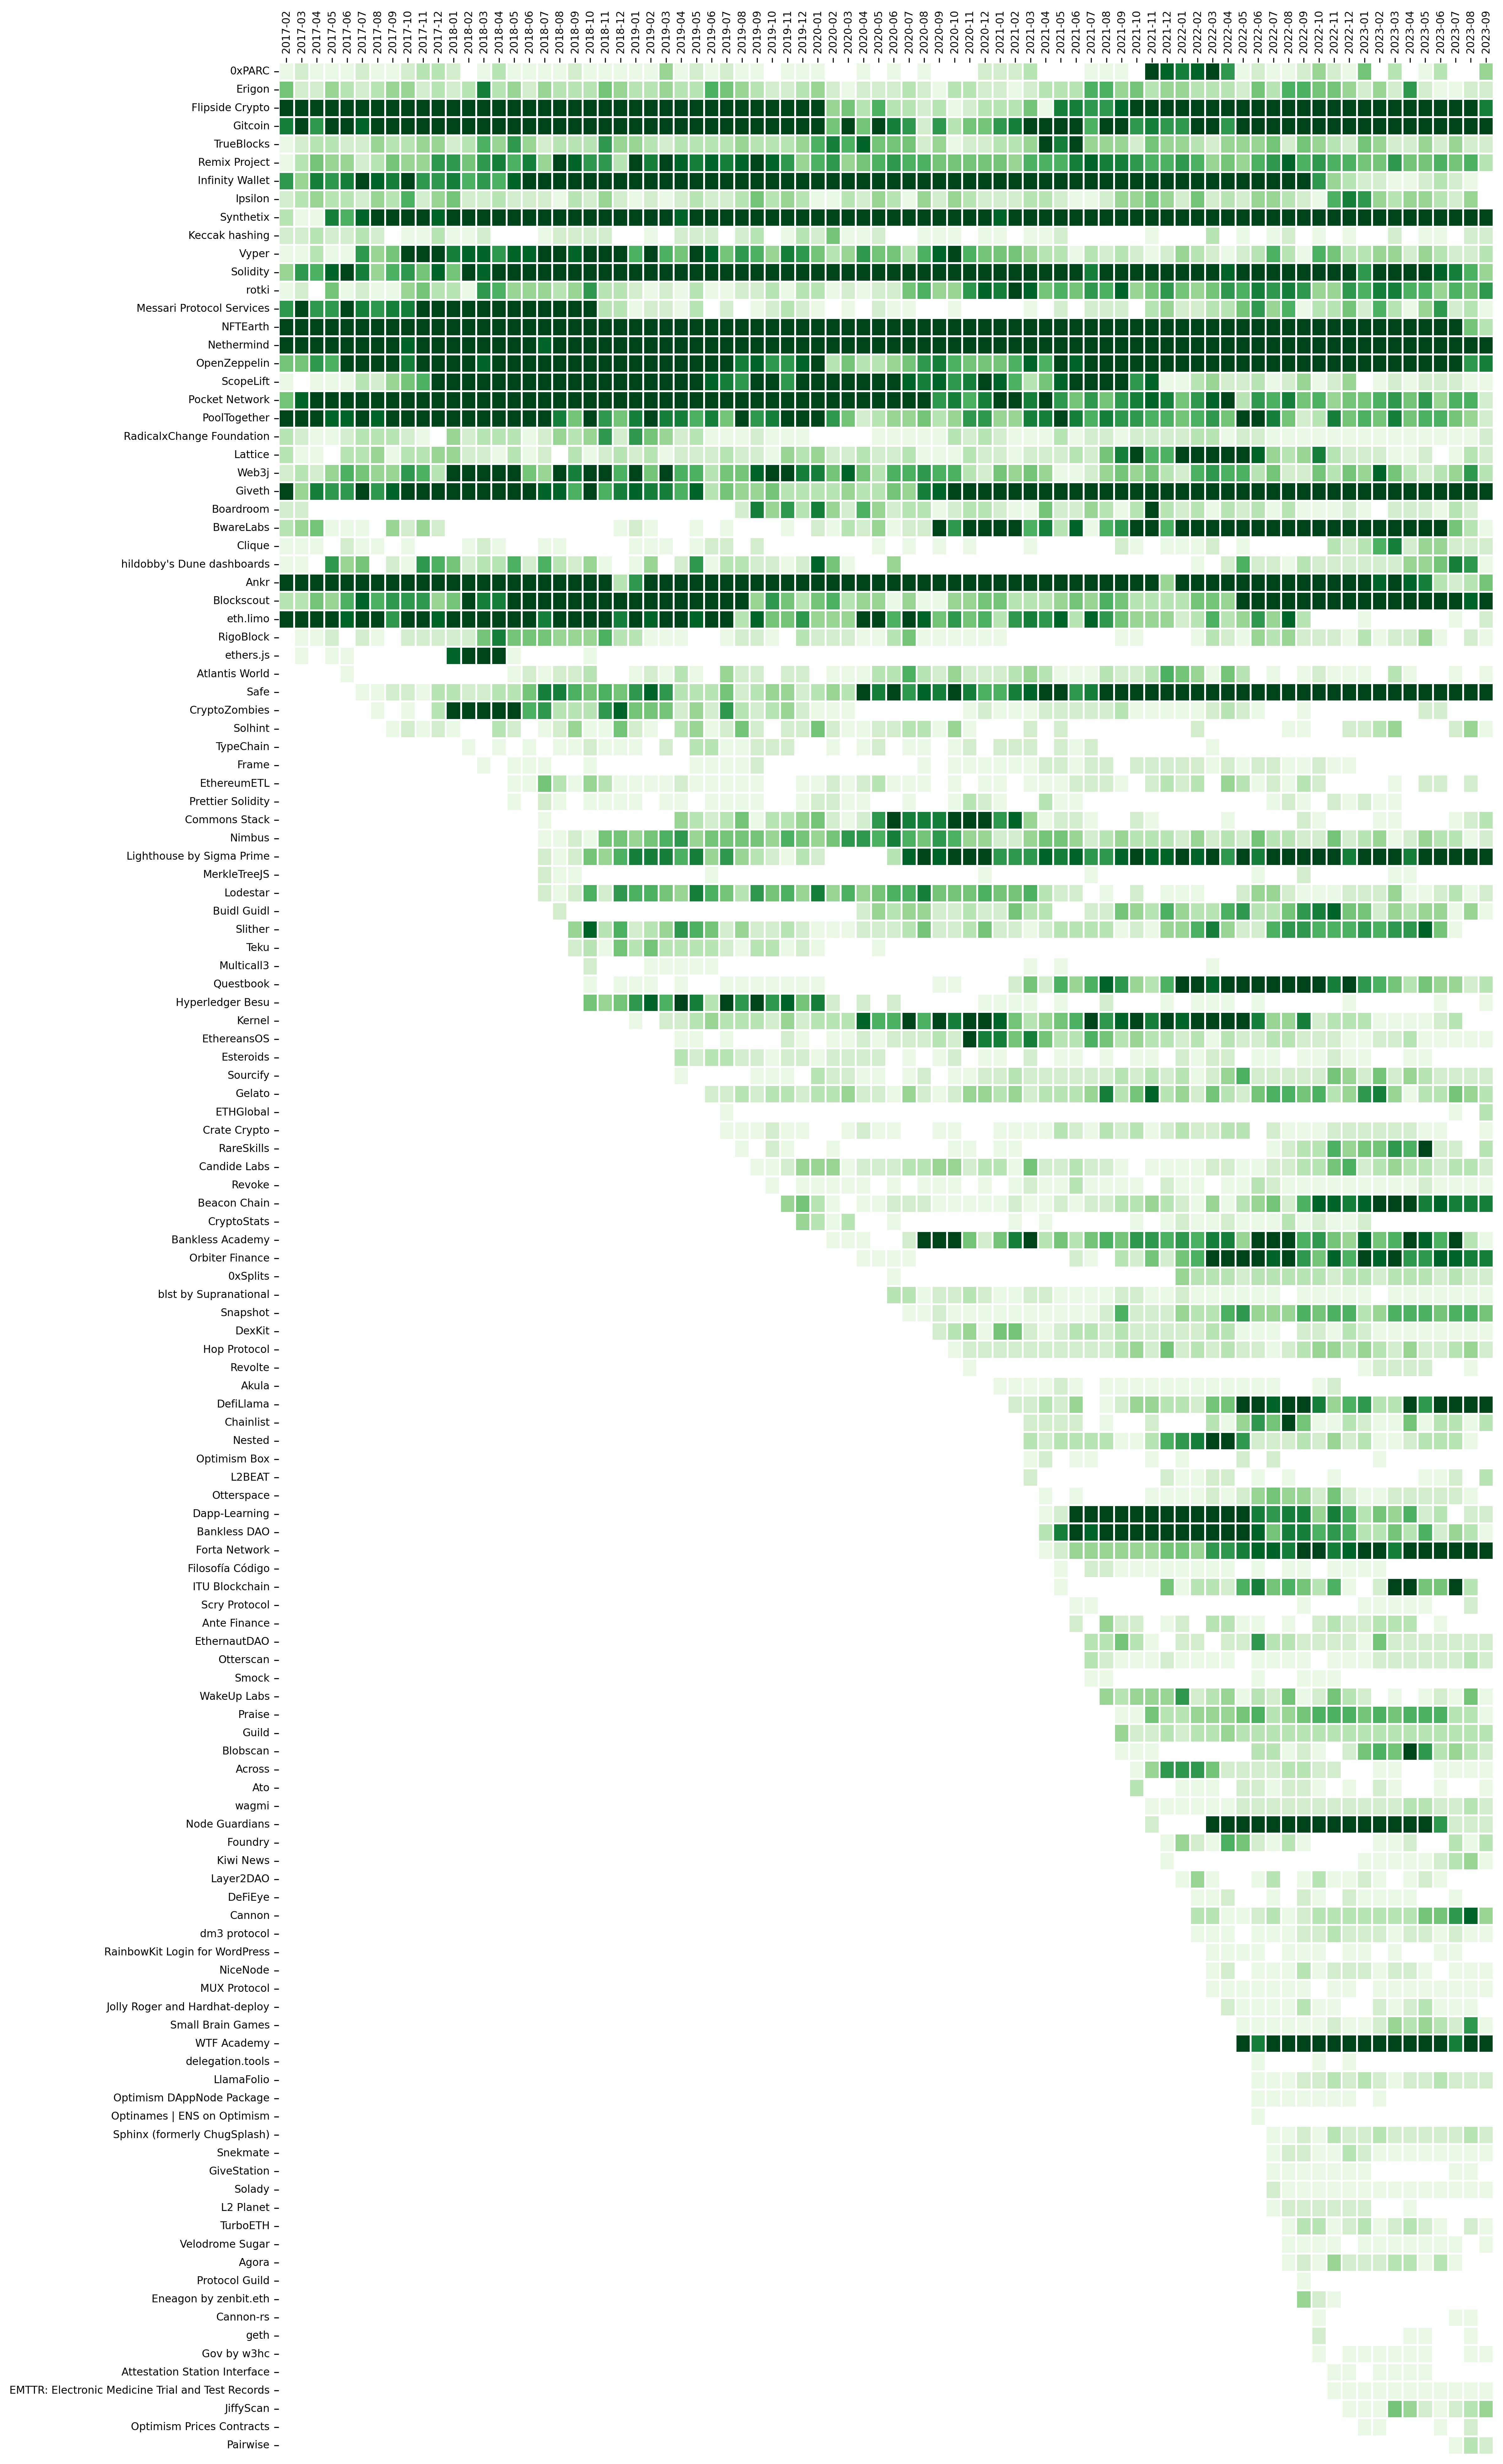

In [85]:
contribution_heatmap(contributors[contributors['project_slug'].isin(cp_mapping['op-rpgf2'])])